#**Final Project-Phishing URL Detection Using Machine Learning**

**Loading the Dataset**

In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/Dataset_phishing.csv'
dataset = pd.read_csv(file_path)

# Extract dataset information
num_instances = dataset.shape[0]
num_features = dataset.shape[1]

print(f"Number of Instances: {num_instances}")
print(f"Number of Features: {num_features}")

dataset.head()

Number of Instances: 11430
Number of Features: 89


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


**Data Preprocessing**

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Encode the target variable
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

# Drop the "url" column
dataset_preprocessed = dataset.drop(columns=['url'])

# Scale features
scaler = StandardScaler()
features = dataset_preprocessed.drop(columns=['status'])
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Add PCA components back to the dataset
dataset_preprocessed['PCA1'] = features_pca[:, 0]
dataset_preprocessed['PCA2'] = features_pca[:, 1]


**Exploratory Data Analysis**

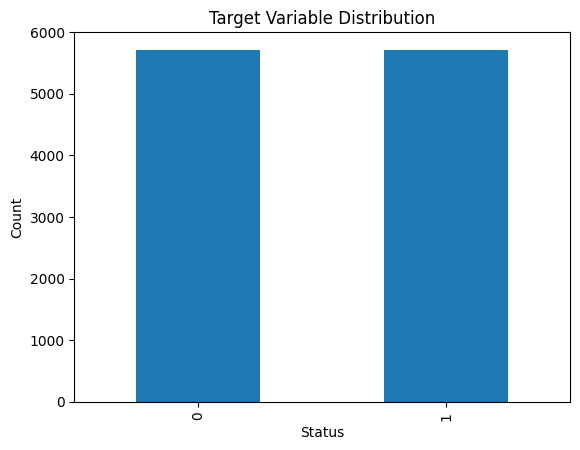

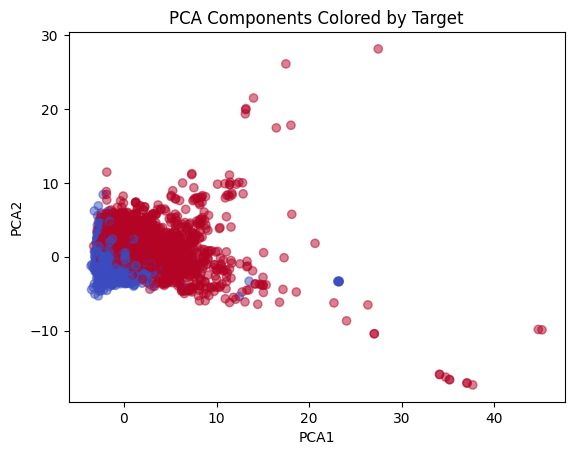

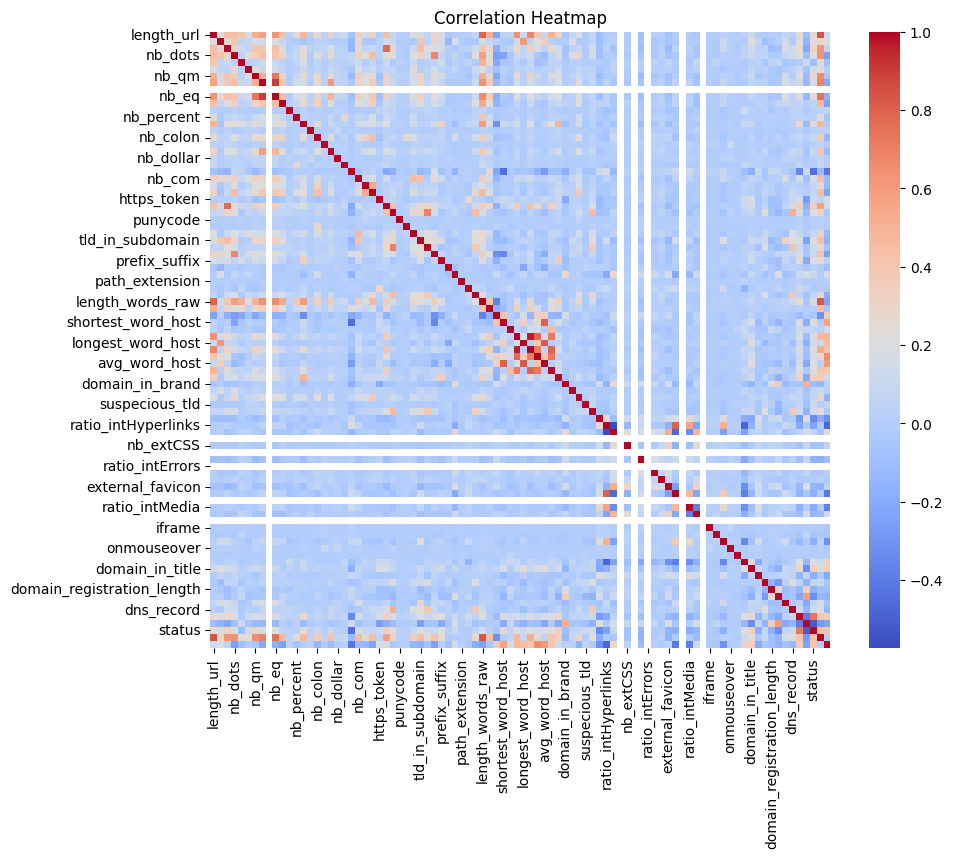

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target variable distribution
dataset['status'].value_counts().plot(kind='bar', title="Target Variable Distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

# PCA scatter plot
plt.scatter(dataset_preprocessed['PCA1'], dataset_preprocessed['PCA2'], c=dataset_preprocessed['status'], cmap='coolwarm', alpha=0.5)
plt.title("PCA Components Colored by Target")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Correlation heatmap
correlation_matrix = dataset_preprocessed.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


**Training the Dataset**

In [5]:
from sklearn.model_selection import train_test_split

# Split data
X = dataset_preprocessed.drop(columns=['status'])
y = dataset_preprocessed['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=100)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Testing set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
status
1    0.500062
0    0.499938
Name: proportion, dtype: float64
Testing set class distribution:
status
0    0.500146
1    0.499854
Name: proportion, dtype: float64


**1. Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


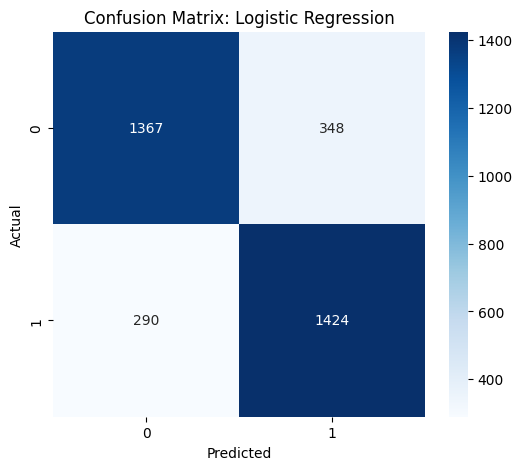

|                     |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC |
|:--------------------|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|
| Logistic Regression |          1.56308 |            0.00843954 |    0.81394 |    0.803612 | 0.830805 |   0.816982 |  0.894008 |


In [6]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Measure training time
start_time = time.time()
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
train_time_lr = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_lr = clf_lr.predict(X_test)
y_prob_lr = clf_lr.predict_proba(X_test)[:, 1]
prediction_time_lr = time.time() - start_time

# Evaluate
cm_lr = confusion_matrix(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Metrics in Table Format
metrics_lr = {
    "Train Time (s)": [train_time_lr],
    "Prediction Time (s)": [prediction_time_lr],
    "Accuracy": [report_lr["accuracy"]],
    "Precision": [report_lr["1"]["precision"]],
    "Recall": [report_lr["1"]["recall"]],
    "F1-Score": [report_lr["1"]["f1-score"]],
    "ROC AUC": [roc_auc_lr]
}
df_lr = pd.DataFrame(metrics_lr, index=["Logistic Regression"])
print(df_lr.to_markdown())


**2. Decision Tree**

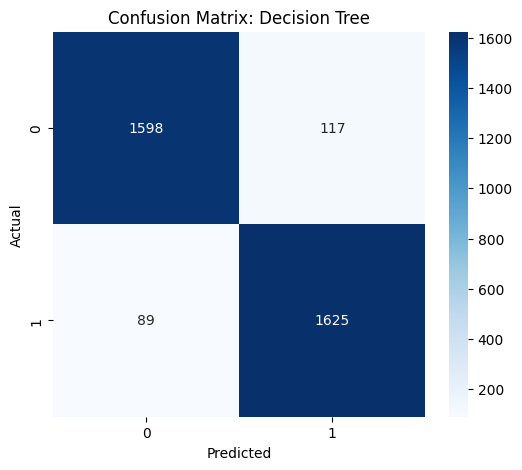

|               |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC |
|:--------------|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|
| Decision Tree |         0.224718 |            0.00644064 |   0.939924 |    0.932836 | 0.948075 |   0.940394 |  0.939927 |


In [7]:
from sklearn.tree import DecisionTreeClassifier

# Measure training time
start_time = time.time()
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)
train_time_dt = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_dt = clf_dt.predict(X_test)
y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]
prediction_time_dt = time.time() - start_time

# Evaluate
cm_dt = confusion_matrix(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Metrics in Table Format
metrics_dt = {
    "Train Time (s)": [train_time_dt],
    "Prediction Time (s)": [prediction_time_dt],
    "Accuracy": [report_dt["accuracy"]],
    "Precision": [report_dt["1"]["precision"]],
    "Recall": [report_dt["1"]["recall"]],
    "F1-Score": [report_dt["1"]["f1-score"]],
    "ROC AUC": [roc_auc_dt]
}
df_dt = pd.DataFrame(metrics_dt, index=["Decision Tree"])
print(df_dt.to_markdown())


**3. Neural Network**

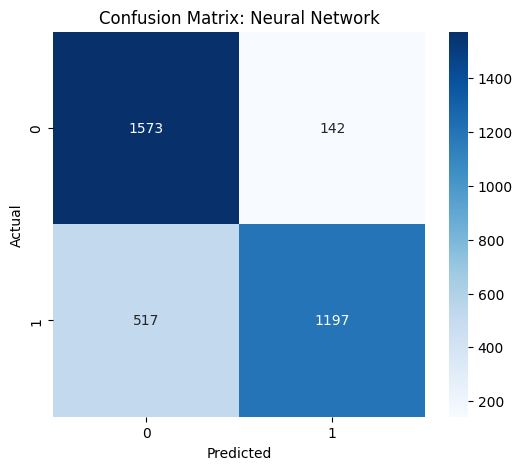

|                |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC |
|:---------------|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|
| Neural Network |            1.777 |             0.0155671 |   0.807816 |    0.893951 | 0.698366 |   0.784147 |  0.787949 |


In [8]:
from sklearn.neural_network import MLPClassifier

# Measure training time
start_time = time.time()
clf_nn = MLPClassifier(max_iter=500, random_state=42)
clf_nn.fit(X_train, y_train)
train_time_nn = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_nn = clf_nn.predict(X_test)
y_prob_nn = clf_nn.predict_proba(X_test)[:, 1]
prediction_time_nn = time.time() - start_time

# Evaluate
cm_nn = confusion_matrix(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
report_nn = classification_report(y_test, y_pred_nn, output_dict=True)

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Metrics in Table Format
metrics_nn = {
    "Train Time (s)": [train_time_nn],
    "Prediction Time (s)": [prediction_time_nn],
    "Accuracy": [report_nn["accuracy"]],
    "Precision": [report_nn["1"]["precision"]],
    "Recall": [report_nn["1"]["recall"]],
    "F1-Score": [report_nn["1"]["f1-score"]],
    "ROC AUC": [roc_auc_nn]
}
df_nn = pd.DataFrame(metrics_nn, index=["Neural Network"])
print(df_nn.to_markdown())


**4. SVM**

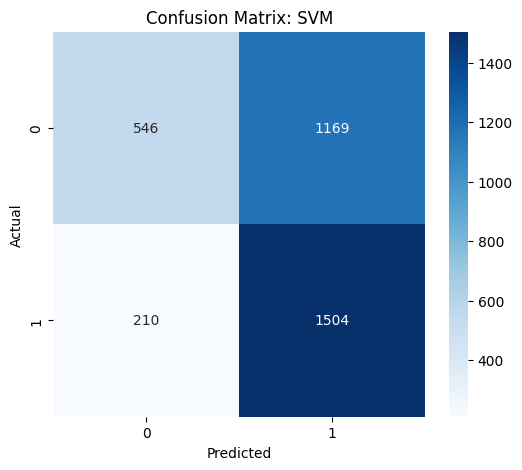

|     |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC |
|:----|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|
| SVM |          31.0071 |               4.29444 |   0.597842 |    0.562664 |  0.87748 |   0.685662 |  0.773546 |


In [9]:
from sklearn.svm import SVC

# Measure training time
start_time = time.time()
clf_svm = SVC(probability=True, random_state=42)
clf_svm.fit(X_train, y_train)
train_time_svm = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_svm = clf_svm.predict(X_test)
y_prob_svm = clf_svm.predict_proba(X_test)[:, 1]
prediction_time_svm = time.time() - start_time

# Evaluate
cm_svm = confusion_matrix(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Metrics in Table Format
metrics_svm = {
    "Train Time (s)": [train_time_svm],
    "Prediction Time (s)": [prediction_time_svm],
    "Accuracy": [report_svm["accuracy"]],
    "Precision": [report_svm["1"]["precision"]],
    "Recall": [report_svm["1"]["recall"]],
    "F1-Score": [report_svm["1"]["f1-score"]],
    "ROC AUC": [roc_auc_svm]
}
df_svm = pd.DataFrame(metrics_svm, index=["SVM"])
print(df_svm.to_markdown())


**5. KNN**

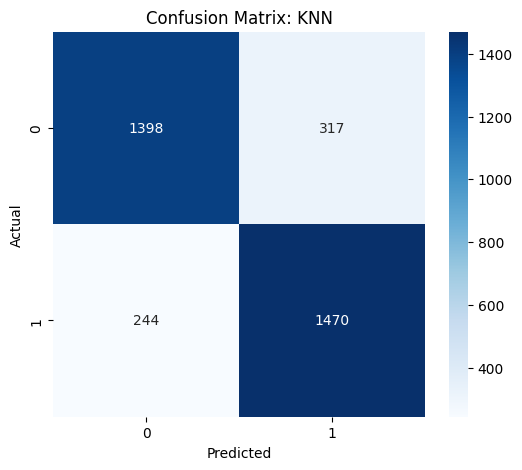

|     |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC |
|:----|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|
| KNN |        0.0103347 |              0.770439 |   0.836395 |    0.822608 | 0.857643 |    0.83976 |  0.908376 |


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Measure training time
start_time = time.time()
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
train_time_knn = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_knn = clf_knn.predict(X_test)
y_prob_knn = clf_knn.predict_proba(X_test)[:, 1]
prediction_time_knn = time.time() - start_time

# Evaluate
cm_knn = confusion_matrix(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Metrics in Table Format
metrics_knn = {
    "Train Time (s)": [train_time_knn],
    "Prediction Time (s)": [prediction_time_knn],
    "Accuracy": [report_knn["accuracy"]],
    "Precision": [report_knn["1"]["precision"]],
    "Recall": [report_knn["1"]["recall"]],
    "F1-Score": [report_knn["1"]["f1-score"]],
    "ROC AUC": [roc_auc_knn]
}
df_knn = pd.DataFrame(metrics_knn, index=["KNN"])
print(df_knn.to_markdown())


**ROC Curve**

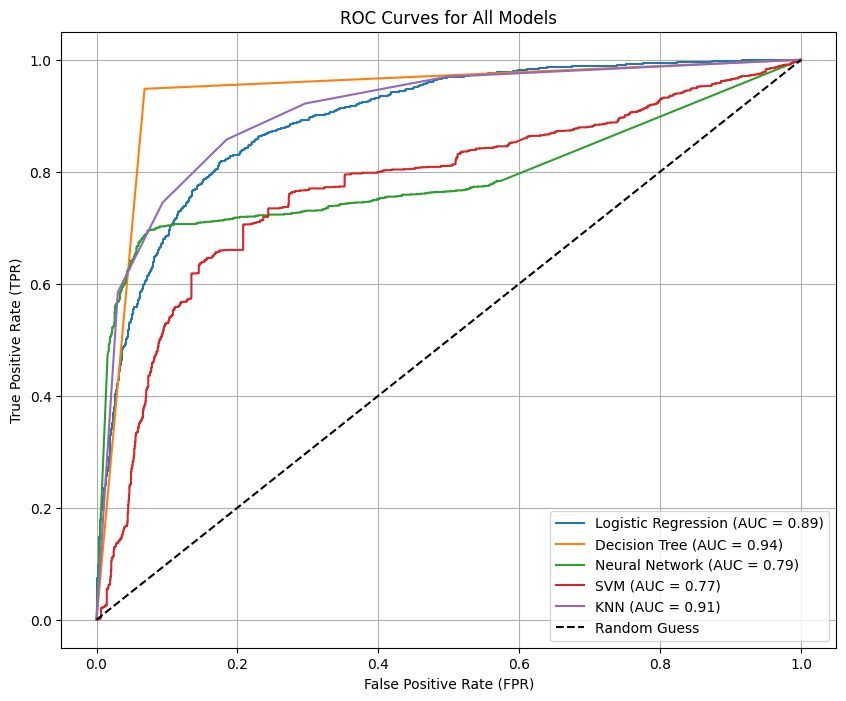

In [18]:
from sklearn.metrics import roc_curve, auc

classifiers = {
    "Logistic Regression": clf_lr,
    "Decision Tree": clf_dt,
    "Neural Network": clf_nn,
    "SVM": clf_svm,
    "KNN": clf_knn
}

# Plot ROC curves for all classifiers
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    try:
        # Compute ROC curve and AUC
        y_prob = clf.predict_proba(X_test)[:, 1]  # Get probabilities
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    except AttributeError:
        print(f"{name} does not support predict_proba. Skipping...")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()



**Comparison of Metrics as a Dataframe**

In [19]:
# Add Model column to each individual DataFrame
df_lr["Model"] = "Logistic Regression"
df_dt["Model"] = "Decision Tree"
df_nn["Model"] = "Neural Network"
df_svm["Model"] = "SVM"
df_knn["Model"] = "KNN"

# Combine results from all models
df_all = pd.concat([df_lr, df_dt, df_nn, df_svm, df_knn], ignore_index=True)

# Print Combined Metrics Table
print(df_all.to_markdown())

|    |   Train Time (s) |   Prediction Time (s) |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC | Model               |
|---:|-----------------:|----------------------:|-----------:|------------:|---------:|-----------:|----------:|:--------------------|
|  0 |        1.56308   |            0.00843954 |   0.81394  |    0.803612 | 0.830805 |   0.816982 |  0.894008 | Logistic Regression |
|  1 |        0.224718  |            0.00644064 |   0.939924 |    0.932836 | 0.948075 |   0.940394 |  0.939927 | Decision Tree       |
|  2 |        1.777     |            0.0155671  |   0.807816 |    0.893951 | 0.698366 |   0.784147 |  0.787949 | Neural Network      |
|  3 |       31.0071    |            4.29444    |   0.597842 |    0.562664 | 0.87748  |   0.685662 |  0.773546 | SVM                 |
|  4 |        0.0103347 |            0.770439   |   0.836395 |    0.822608 | 0.857643 |   0.83976  |  0.908376 | KNN                 |


**Comparison of Metrics as Bar Chart**

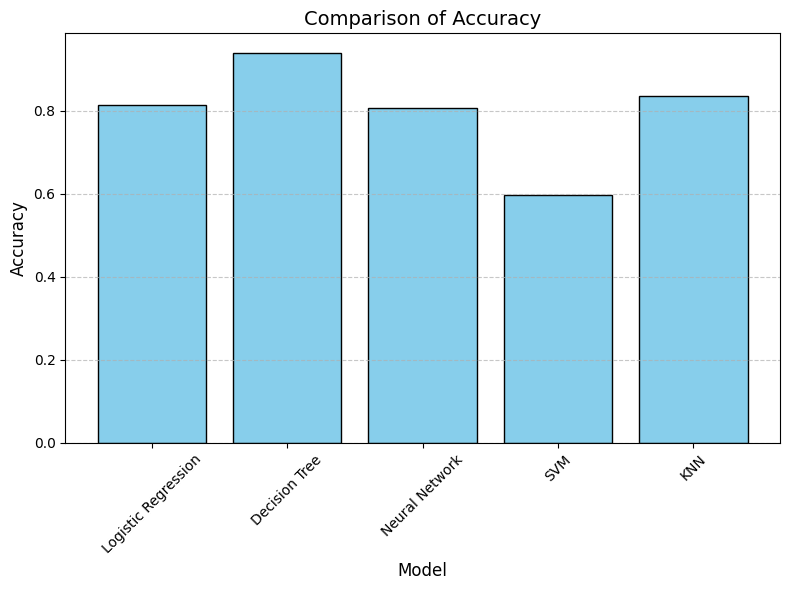

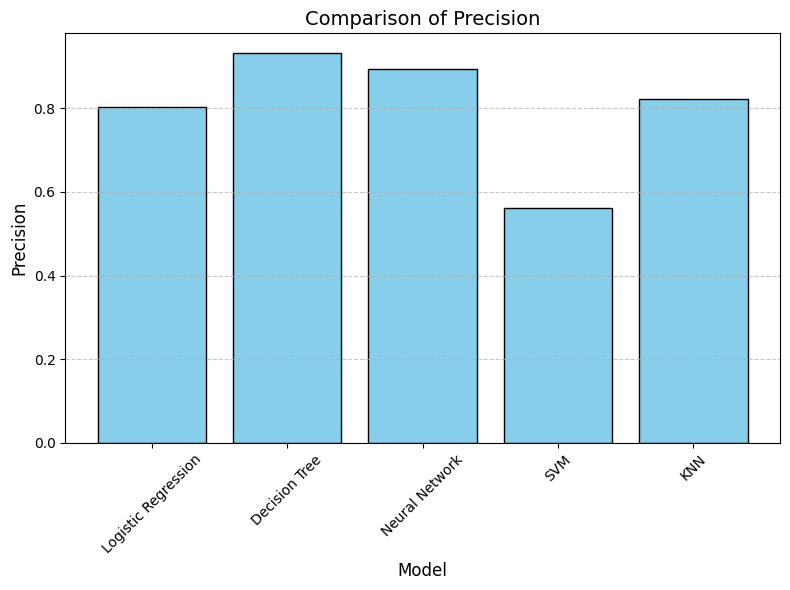

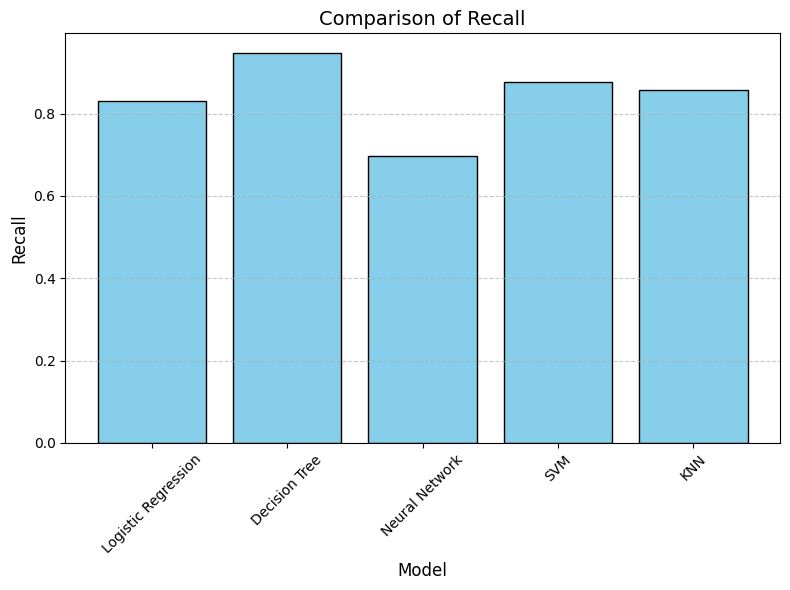

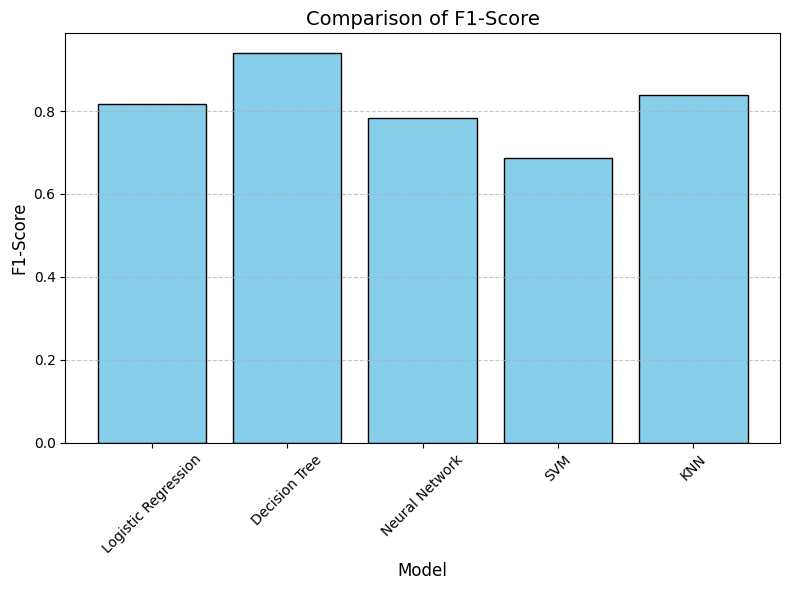

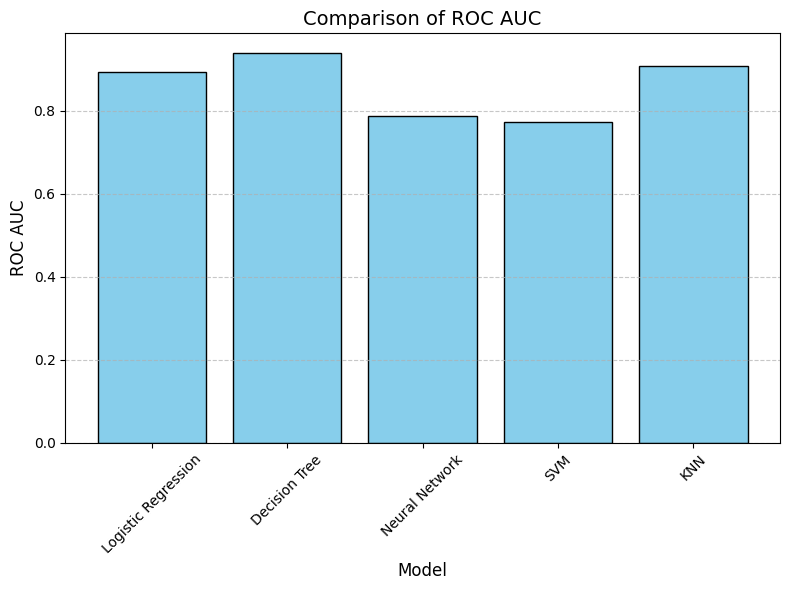

In [20]:
# Combine metrics for visualization
df_all = pd.concat([df_lr, df_dt, df_nn, df_svm, df_knn])  # Combine all individual model metrics
df_all.reset_index(drop=True, inplace=True)  # Reset index to ensure proper alignment

# Visualize metrics for all models
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"]

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.bar(df_all["Model"], df_all[metric], color='skyblue', edgecolor='black')
    plt.title(f"Comparison of {metric}", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


**Choosing the Best Model**

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate  # For better table formatting

scaler = MinMaxScaler()
df_all["Train Time (normalized)"] = 1 - scaler.fit_transform(df_all[["Train Time (s)"]])
df_all["Prediction Time (normalized)"] = 1 - scaler.fit_transform(df_all[["Prediction Time (s)"]])

# Define weights for the metrics
weights = {
    "ROC AUC": 0.4,                      # Most important metric
    "Accuracy": 0.2,                     # Second priority
    "F1-Score": 0.2,                     # Balances precision and recall
    "Train Time (normalized)": 0.1,      # Efficiency in training
    "Prediction Time (normalized)": 0.1, # Efficiency in predictions
}

# Calculate weighted score dynamically
df_all["Weighted Score"] = (
    df_all["ROC AUC"] * weights["ROC AUC"]
    + df_all["Accuracy"] * weights["Accuracy"]
    + df_all["F1-Score"] * weights["F1-Score"]
    + df_all["Train Time (normalized)"] * weights["Train Time (normalized)"]
    + df_all["Prediction Time (normalized)"] * weights["Prediction Time (normalized)"]
)

# Sort by weighted score
df_all = df_all.sort_values(by="Weighted Score", ascending=False)

# Print the metrics table
print("\nMetrics Table:")
print(tabulate(df_all, headers="keys", tablefmt="pretty"))

# Find the best model
best_model_row = df_all.iloc[0]
best_model_name = best_model_row["Model"]

print("\nBest Model Based on Weighted Scoring:")
print(tabulate([best_model_row], headers="keys", tablefmt="pretty"))



Metrics Table:
+---+---------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+-------------------------+------------------------------+--------------------+
|   |   Train Time (s)    | Prediction Time (s)  |      Accuracy      |     Precision      |       Recall       |      F1-Score      |      ROC AUC       |        Model        | Train Time (normalized) | Prediction Time (normalized) |   Weighted Score   |
+---+---------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+-------------------------+------------------------------+--------------------+
| 1 | 0.2247180938720703  | 0.006440639495849609 | 0.9399241761446486 | 0.9328358208955224 | 0.9480746791131855 | 0.9403935185185185 | 0.9399265523845811 |    Decision Tree    |   0.9930836762193558    |             

**Improving the Decission Tree model using Hyper-Parameter Tuning**

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

from sklearn.model_selection import RandomizedSearchCV

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf_dt, param_distributions=param_grid, n_iter=50,
                                   cv=5, scoring="accuracy", random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best Parameters from RandomizedSearchCV:", best_params)

# Predictions and probabilities
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Improved Accuracy: {accuracy:.4f}")
print(f"Improved ROC AUC: {roc_auc:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from RandomizedSearchCV: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Improved Accuracy: 0.9411
Improved ROC AUC: 0.9403
